In [1]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils
from keras import layers
from keras import optimizers
from keras.models import Model
from keras.models import Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from keras.models import Sequential

In [2]:
df = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape', error_bad_lines=False)
df = df.fillna(method="ffill")
df["Sentence #"] = df["Sentence #"].apply(lambda s: s[9:])
df["Sentence #"] = df["Sentence #"].astype("int32")
df.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [3]:
df.shape

(1048575, 4)

In [4]:
# Finding unique words
words = set(list(df.Word.values))
tags = set(list(df.Tag.values))
n_words = len(words)
n_tags = len(tags)
print("Words = ", n_words, " Tags = ", n_tags)

Words =  35178  Tags =  17


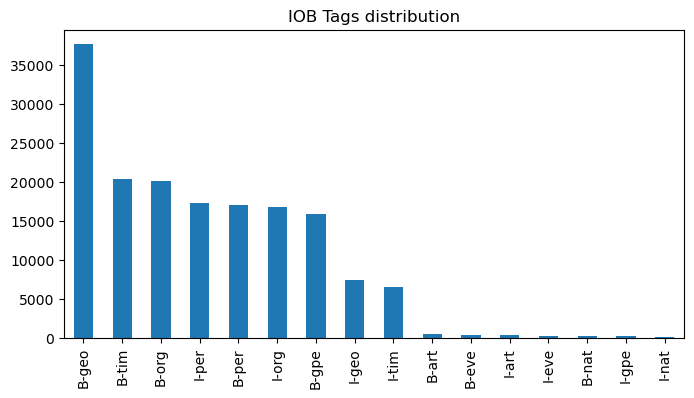

In [5]:
df[df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(8,4), title='IOB Tags distribution')
plt.show()

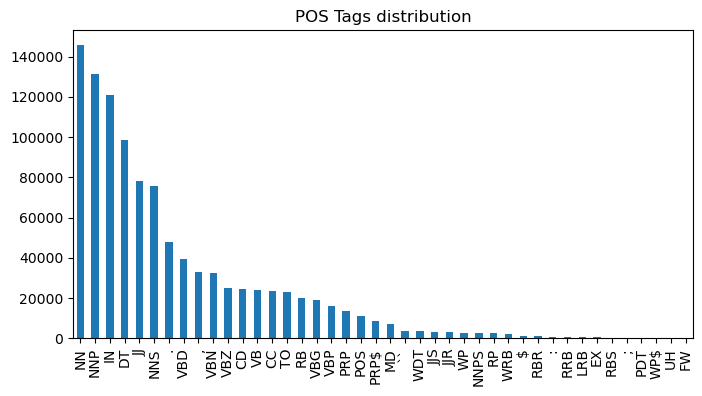

In [6]:
df["POS"].value_counts().plot(kind="bar", figsize=(8,4), title='POS Tags distribution')
plt.show()

In [7]:
# Converting all unique tokens to indices

word2index = {w:i+2 for i,w in enumerate(words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1
index2word = {i:w for w,i in word2index.items()}
tag2index = {t:i + 1 for i,t in enumerate(tags)}
tag2index["--PADDING--"] = 0
index2tag = {i:t for t,i in tag2index.items()}


In [8]:
# Extracting tuples of (words, POS, tags) from dataset

def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]
sentences = df.groupby("Sentence #").apply(to_tuples).tolist()
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

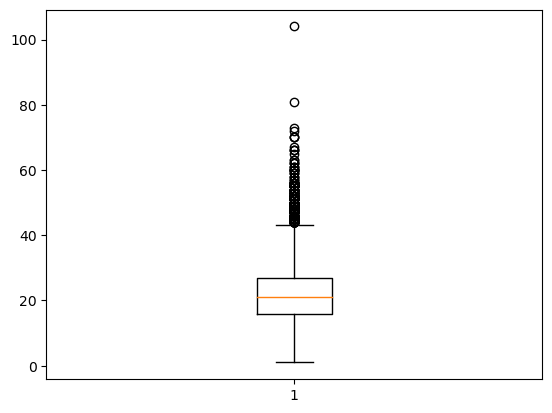

In [9]:
# Finding the distribution of length of sentences
plt.boxplot([len(sen) for sen in sentences])
plt.show()

In [10]:
# Constructing the features and targets

X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [11]:
# Replacing words and tags with their respective indices

X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [21372, 25351, 31721, 25076, 26721, 27294, 17740, 9478, 15590, 28636, 11441, 29503, 21911, 33976, 19481, 28636, 7586, 25351, 19159, 361, 521, 16184, 3202, 8818]
y[0]: [4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 17, 4, 4, 4, 4, 4]


In [12]:
# Set a max length and pad sentences as LSTM expects a fixed length imput
max_len=70
X = pad_sequences(X, maxlen=max_len, dtype='int32', truncating = 'post', padding='post', value= [word2index["--PADDING--"]])
y = pad_sequences(y, maxlen=max_len, dtype='int32', truncating = 'post', padding='post', value= [tag2index["--PADDING--"]]) 
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [21372 25351 31721 25076 26721 27294 17740  9478 15590 28636 11441 29503
 21911 33976 19481 28636  7586 25351 19159   361   521 16184  3202  8818
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1]
y[0]: [ 4  4  4  4  4  4  2  4  4  4  4  4  2  4  4  4  4  4 17  4  4  4  4  4
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [13]:
# Converting targets to categorical

n_tags = len(tag2index)
y = [ np.eye(n_tags)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [21372 25351 31721 25076 26721 27294 17740  9478 15590 28636 11441 29503
 21911 33976 19481 28636  7586 25351 19159   361   521 16184  3202  8818
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1]
y[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [14]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset    : {}".format(len(X_test)))

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset    : 4796


In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [16]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 10

In [17]:
def bilstm_lstm_model():
    model = Sequential()
    
    # Add Embedding layer
    model.add(Embedding(input_dim=WORD_COUNT, output_dim=DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=max_len))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=LSTM_DROPOUT), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=LSTM_UNITS, return_sequences=True, dropout=0.5, recurrent_dropout=LSTM_DROPOUT))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))
    
    #Optimiser 
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

    # Compile model
    #crf_layer = CRF(units=n_tags)
    #acc_metric = metrics.crf_accuracy
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    
    return model

In [18]:
ner_model = bilstm_lstm_model()
plot_model(ner_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 50)            1759000   
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 100)           40400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 50)            30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 18)            918       
Total params: 1,830,518
Trainable params: 1,830,518
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [19]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)

Epoch 1/10
152/152 - 85s - loss: 0.7516 - accuracy: 0.9153 - val_loss: 0.4764 - val_accuracy: 0.9453
Epoch 2/10
152/152 - 91s - loss: 0.4644 - accuracy: 0.9425 - val_loss: 0.3835 - val_accuracy: 0.9470
Epoch 3/10
152/152 - 98s - loss: 0.3953 - accuracy: 0.9442 - val_loss: 0.3487 - val_accuracy: 0.9415
Epoch 4/10
152/152 - 98s - loss: 0.3649 - accuracy: 0.9441 - val_loss: 0.3237 - val_accuracy: 0.9449
Epoch 5/10
152/152 - 98s - loss: 0.3373 - accuracy: 0.9463 - val_loss: 0.2875 - val_accuracy: 0.9492
Epoch 6/10
152/152 - 102s - loss: 0.3126 - accuracy: 0.9463 - val_loss: 0.2753 - val_accuracy: 0.9498
Epoch 7/10
152/152 - 97s - loss: 0.2960 - accuracy: 0.9463 - val_loss: 0.3053 - val_accuracy: 0.9438
Epoch 8/10
152/152 - 95s - loss: 0.2990 - accuracy: 0.9466 - val_loss: 0.2594 - val_accuracy: 0.9505
Epoch 9/10
152/152 - 97s - loss: 0.3266 - accuracy: 0.9456 - val_loss: 0.2824 - val_accuracy: 0.9502
Epoch 10/10
152/152 - 94s - loss: 0.2967 - accuracy: 0.9467 - val_loss: 0.2658 - val_accur

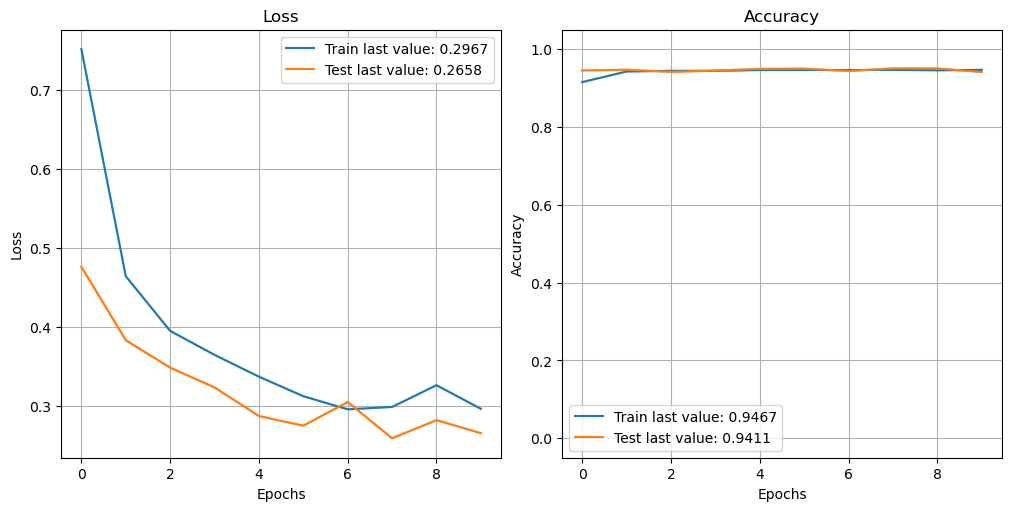

In [20]:
plot_history(history.history)
plt.show()

In [21]:
y_pred = ner_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=2)
y_test = np.argmax(y_test, axis=2)
accuracy = (y_pred == y_test).mean()
print("Accuracy: {:.4f}\n".format(accuracy))

Accuracy: 0.9407



In [22]:
# Constructing confusion matrices for each tag to judge model performance based on those as the dataset is highly imbalanced

def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))
matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())
tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: I-geo
[[334963      0]
 [   757      0]]
Tag accuracy: 0.998 

Tag name: B-eve
[[335690      0]
 [    30      0]]
Tag accuracy: 1.000 

